In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def load_dataset(csv_path, hmi_folder_path):
    ## load dataframe and hmi_data
    df = pd.read_csv(csv_path)
    hmi_folder_path = Path(hmi_folder_path)
    hmi_path = df["HMI_img"].apply(lambda x: hmi_folder_path / x)
    hmi_data = np.zeros((len(hmi_path), 224, 224))
    for i in range(len(hmi_path)):
        hmi_data[i] = np.load(hmi_path[i])
    return df, hmi_data


csv_path = "/kaggle/input/csc-480-680-project-2-2025-fall/train_df.csv"
hmi_folder_path = "/kaggle/input/csc-480-680-project-2-2025-fall/HMI_data/HMI_data/"

df, hmi_data = load_dataset(csv_path, hmi_folder_path)

## build dataset
y = df[["tsi_pert_0", "sunspot_area"]].values
X = hmi_data

2025-12-07 20:54:32.101944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765140872.293384      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765140872.344897      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

* Dataset Overview *
Number of samples: 1794
Image shape: (224, 224) (Height, Width)
Target shape: (1794, 2)

 * Raw Pixel Value Statistics *
Min pixel value: 0.0000
Max pixel value: 71473.9297
Mean pixel value: 31284.4872
Std pixel value: 22627.4010

 * Target Value Statistics *
        tsi_pert_0  sunspot_area
count  1794.000000   1794.000000
mean     -0.039371      0.429086
std       0.330519      0.522641
min      -1.600300      0.000000
25%      -0.282213      0.014000
50%      -0.106675      0.224000
75%       0.198025      0.672000
max       0.911900      2.942800


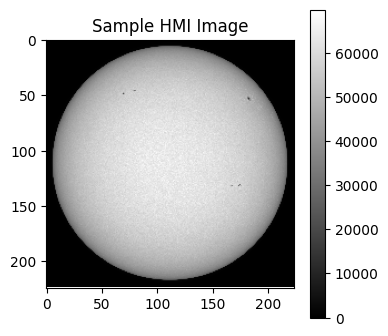

In [2]:
# Raw Dataset Description 

y = df[["tsi_pert_0", "sunspot_area"]].values

print("* Dataset Overview *")
print(f"Number of samples: {hmi_data.shape[0]}")
print(f"Image shape: {hmi_data.shape[1:]} (Height, Width)")
print(f"Target shape: {y.shape}")

print("\n * Raw Pixel Value Statistics *")
print(f"Min pixel value: {hmi_data.min():.4f}")
print(f"Max pixel value: {hmi_data.max():.4f}")
print(f"Mean pixel value: {hmi_data.mean():.4f}")
print(f"Std pixel value: {hmi_data.std():.4f}")

print("\n * Target Value Statistics *")
print(df[["tsi_pert_0", "sunspot_area"]].describe())

# Visualize a sample image
plt.figure(figsize=(4,4))
plt.imshow(hmi_data[0], cmap="gray")
plt.title("Sample HMI Image")
plt.colorbar()
plt.show()


In [3]:
# Normalize image pixel values 
X_img = hmi_data / np.max(hmi_data)       # scale pixels
#Add channel 
X_img = X_img[..., np.newaxis]            # (N,224,224,1)

Shape of X_img: (1794, 224, 224, 1)
Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.43770487073321956
Std pixel value: 0.3165825790258766
Sample image pixel values (first image, first 10 pixels): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


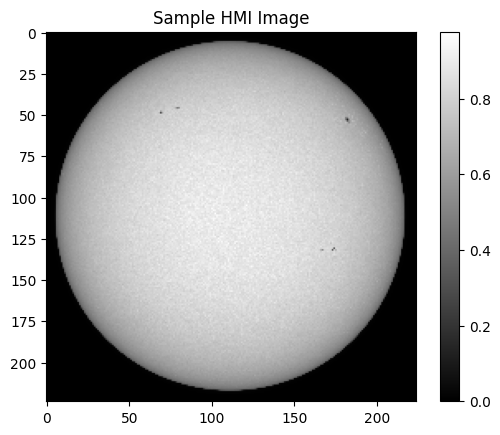

In [4]:
# Confirm new shape 
print("Shape of X_img:", X_img.shape)  # (num_samples, 224, 224, 1)

# Pixel value statistics
print("Min pixel value:", X_img.min())
print("Max pixel value:", X_img.max())
print("Mean pixel value:", X_img.mean())
print("Std pixel value:", X_img.std())

# Print a sample image's pixel values (flattened)
print("Sample image pixel values (first image, first 10 pixels):", X_img[0].flatten()[:10])

# View Image
import matplotlib.pyplot as plt
plt.imshow(X_img[0,:,:,0], cmap="gray")
plt.title("Sample HMI Image")
plt.colorbar()
plt.show()

In [5]:
#Standardize the features using standardscaler 
ssa_cols = [f'tavg_{i}' for i in range(10)] + [f'tmed_{i}' for i in range(10)] + ['tcnt_0']

X_ssa = df[ssa_cols].values
scaler = StandardScaler()
X_ssa = scaler.fit_transform(X_ssa)


In [6]:
# Convert the DataFrame to a NumPy array
y = df[["tsi_pert_0", "sunspot_area"]].values


In [7]:
# Split the dataset into training and validation sets
X_img_tr, X_img_val, X_ssa_tr, X_ssa_val, y_tr, y_val = train_test_split(
    X_img, X_ssa, y, test_size=0.2, random_state=42
)

In [8]:
# Fit the generator on training images to prevent overfitting  
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

In [9]:

def build_model():
    # Define model inputs
    img_input = tf.keras.Input(shape=(224,224,1), name="img_input")
    num_input = tf.keras.Input(shape=(21,), name="num_input")

    # CNN branch for images
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(img_input)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    # Dense branch for numeric features
    n = tf.keras.layers.Dense(256, activation="relu")(num_input)
    n = tf.keras.layers.Dropout(0.3)(n)
    n = tf.keras.layers.Dense(32, activation="relu")(n)
    n = tf.keras.layers.Dropout(0.2)(n)

    # Merge branches
    merged = tf.keras.layers.Concatenate()([x, n])
    shared = tf.keras.layers.Dense(64, activation="relu")(merged)
    shared = tf.keras.layers.Dropout(0.2)(shared)

    # Multitask outputs
    tsi_output = tf.keras.layers.Dense(1, name="tsi_output")(shared)
    sunspot_output = tf.keras.layers.Dense(1, name="sunspot_output")(shared)

    # Build and return the model
    model = tf.keras.Model([img_input, num_input], [tsi_output, sunspot_output])
    return model


In [10]:
n_models = 3
ensemble_models = []

# Early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",   # monitor validation loss
    patience=5,          
    restore_best_weights=True  
)

histories = []

for i in range(n_models):
    model = build_model()
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics={"tsi_output":"mae", "sunspot_output":"mae"}
    )

    history = model.fit(
        [X_img_tr, X_ssa_tr],
        [y_tr[:,0], y_tr[:,1]],
        validation_data=([X_img_val, X_ssa_val], [y_val[:,0], y_val[:,1]]),
        epochs=50,
        batch_size=16,
        callbacks=[early_stop],
        verbose=1
    )

    ensemble_models.append(model)
    histories.append(history)


I0000 00:00:1765140904.728366      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765140904.729075      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1765140909.870140     112 service.cc:148] XLA service 0x7f88a0027e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765140909.870863     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765140909.870882     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765140910.354371     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/90 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.5789 - sunspot_output_loss: 0.4641 - sunspot_output_mae: 0.4581 - tsi_output_loss: 0.1148 - tsi_output_mae: 0.2997  

I0000 00:00:1765140917.292501     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - loss: 0.3886 - sunspot_output_loss: 0.2713 - sunspot_output_mae: 0.3560 - tsi_output_loss: 0.1174 - tsi_output_mae: 0.2521 - val_loss: 0.4168 - val_sunspot_output_loss: 0.3185 - val_sunspot_output_mae: 0.3486 - val_tsi_output_loss: 0.0890 - val_tsi_output_mae: 0.2142
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3056 - sunspot_output_loss: 0.2053 - sunspot_output_mae: 0.3164 - tsi_output_loss: 0.1003 - tsi_output_mae: 0.2173 - val_loss: 0.3252 - val_sunspot_output_loss: 0.2316 - val_sunspot_output_mae: 0.3243 - val_tsi_output_loss: 0.0868 - val_tsi_output_mae: 0.1896
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2837 - sunspot_output_loss: 0.1922 - sunspot_output_mae: 0.3041 - tsi_output_loss: 0.0916 - tsi_output_mae: 0.2124 - val_loss: 0.2993 - val_sunspot_output_loss: 0.2264 - val_sunspot_output_mae: 0.3125 - val_tsi_output_loss: 0.0667 - val_tsi_output_mae: 0.1770
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/

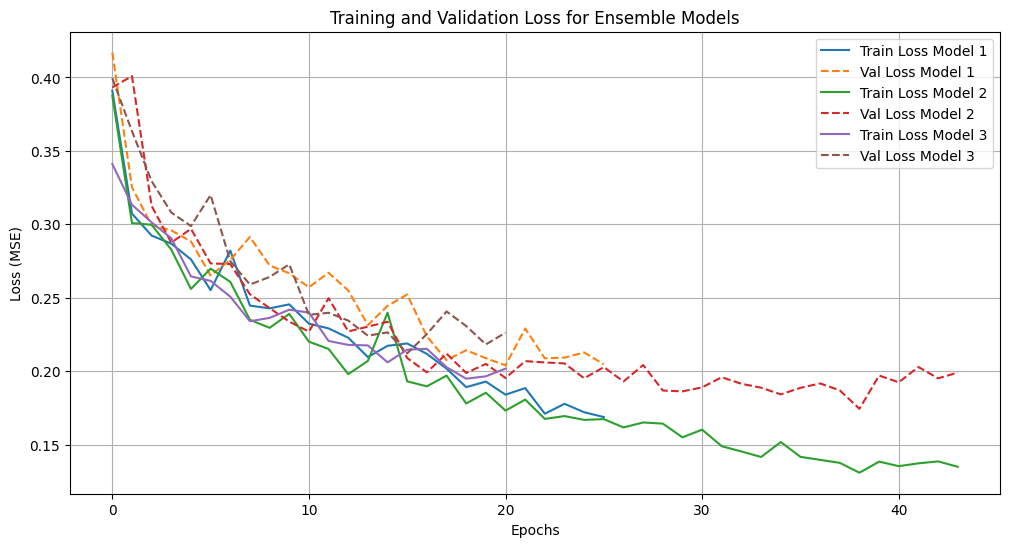

In [11]:
# Plot training and validation loss for each ensemble model
plt.figure(figsize=(12, 6))

for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Loss Model {i+1}')
    plt.plot(history.history['val_loss'], label=f'Val Loss Model {i+1}', linestyle='--')

plt.title('Training and Validation Loss for Ensemble Models')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Ensemble validation predictions
val_preds = []

for model in ensemble_models:
    val_preds.append(np.hstack(model.predict([X_img_val, X_ssa_val])))

val_preds = np.array(val_preds)
final_val_preds = val_preds.mean(axis=0)

print("Validation MAE (TSI):", mean_absolute_error(y_val[:,0], final_val_preds[:,0]))
print("Validation MAE (Sunspot):", mean_absolute_error(y_val[:,1], final_val_preds[:,1]))

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Validation MAE (TSI): 0.138087173938553
Validation MAE (Sunspot): 0.26187789510322484


In [13]:
# Load test datasets for prediction
def load_test(csv_path):
    df_test, hmi = load_dataset(csv_path, hmi_folder_path)
    hmi = hmi / np.max(hmi)
    hmi = hmi[..., np.newaxis]
    ssa = scaler.transform(df_test[ssa_cols].values)
    return df_test, hmi, ssa

test_csv = "/kaggle/input/csc-480-680-project-2-2025-fall/test_df.csv"
private_csv = "/kaggle/input/csc-480-680-project-2-2025-fall/test_df_private.csv"

df_test, Ximg_test, Xssa_test = load_test(test_csv)
df_private, Ximg_priv, Xssa_priv = load_test(private_csv)

# Make ensemble predictions 
pred_test = []
pred_private = []

for model in ensemble_models:
    pred_test.append(np.hstack(model.predict([Ximg_test, Xssa_test])))
    pred_private.append(np.hstack(model.predict([Ximg_priv, Xssa_priv])))

# Average across ensemble
pred_test_avg = np.mean(pred_test, axis=0)
pred_private_avg = np.mean(pred_private, axis=0)


# Combine predictions and save submission
all_preds = np.vstack([pred_test_avg, pred_private_avg])

# Load sample submission template
submission = pd.read_csv(
    "/kaggle/input/csc-480-680-project-2-2025-fall/sample_submission.csv",
    index_col=0
)

# Assign predictions to columns and preview
submission["tsi_pert_0"] = all_preds[:,0]
submission["sunspot_area"] = all_preds[:,1]

# Save final submission
submission.to_csv("submission.csv")

# Preview
submission.head()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


,tsi_pert_0,sunspot_area
index,,
0,0.283753,0.621512
1,0.316124,0.559738
2,0.280712,0.491147
3,0.239295,0.425918
4,0.214752,0.410981
